**Importing Necessary Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import plotly.express as px
import datetime
from math import pi

import missingno as msno
from sklearn.impute import KNNImputer
# Autoreg, autocorrolationand time series tools...

from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
#from statsmodels.tsa.ar_model import AutoReg
#from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic


plt.style.use('seaborn-whitegrid')

from termcolor import colored

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving city_day.csv to city_day.csv
Saving station_day.csv to station_day.csv
Saving stations.csv to stations.csv


**Exploratory Data Analysis**

In [ ]:
city_day = pd.read_csv('city_day.csv').sort_values(by = ['Date', 'City'])

In [ ]:
print(list(city_day.columns))

['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']


In [ ]:
city_day.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
4294,Bengaluru,2015-01-01,NaN,NaN,3.26,17.33,10.88,20.36,0.33,3.54,10.73,0.56,4.64,NaN,NaN,NaN
7834,Chennai,2015-01-01,NaN,NaN,16.30,15.39,22.68,4.59,1.17,9.20,11.35,0.17,NaN,NaN,NaN,NaN
10229,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
19846,Lucknow,2015-01-01,NaN,NaN,2.11,13.46,4.57,NaN,12.15,169.57,25.92,1.35,3.93,NaN,NaN,NaN


In [ ]:
city_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.8+ MB


In [ ]:
city_day.Date = city_day.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
city_day = city_day.sort_values(by = 'Date')

In [ ]:
print('Date starts from {}, and ends in {}'.format(city_day.Date.min().strftime('%Y-%m-%d'), city_day.Date.max().strftime('%Y-%m-%d')))

Date starts from 2015-01-01, and ends in 2020-07-01


In [ ]:
city_day.corr().AQI.sort_values(ascending = False)

AQI        1.000000
PM10       0.803313
CO         0.683346
PM2.5      0.659181
NO2        0.537071
SO2        0.490586
NOx        0.486450
NO         0.452191
Toluene    0.279992
NH3        0.252019
O3         0.198991
Xylene     0.165532
Benzene    0.044407
Name: AQI, dtype: float64

In [ ]:
# adding all the features with corr less than 0.4

city_day['B_X_O3_NH3'] = city_day['Benzene'] +\
city_day['Xylene'] + city_day['O3'] + city_day['NH3']

city_day['ParticulateMatters'] = city_day['PM2.5'] + city_day['PM10']

corr_with_AQI = city_day.corr().AQI.sort_values(ascending = False)


corr_with_AQI
# from here we can see: we can impute values with linear
# interpolation for the ones that have high value of corr

AQI                   1.000000
ParticulateMatters    0.823098
PM10                  0.803313
CO                    0.683346
PM2.5                 0.659181
B_X_O3_NH3            0.605700
NO2                   0.537071
SO2                   0.490586
NOx                   0.486450
NO                    0.452191
Toluene               0.279992
NH3                   0.252019
O3                    0.198991
Xylene                0.165532
Benzene               0.044407
Name: AQI, dtype: float64

In [ ]:
# how much is the average amount of pollution in each city stations
most_polluted = city_day[['City', 'AQI', 'PM10', 'CO']].groupby(['City']).mean().sort_values(by = 'AQI', ascending = False)
most_polluted

,AQI,PM10,CO
City,,,
Ahmedabad,452.122939,114.584029,22.193407
Delhi,259.487744,232.809229,1.976053
Patna,240.782042,126.747958,1.533591
Gurugram,225.123882,191.504432,1.257516
Lucknow,217.973059,NaN,2.130328
Talcher,172.886819,165.772708,1.847722
Jorapokhar,159.251621,149.657942,0.663049
Brajrajnagar,150.280505,124.217373,1.798274
Kolkata,140.566313,115.629499,0.799251


**Data Visualization**

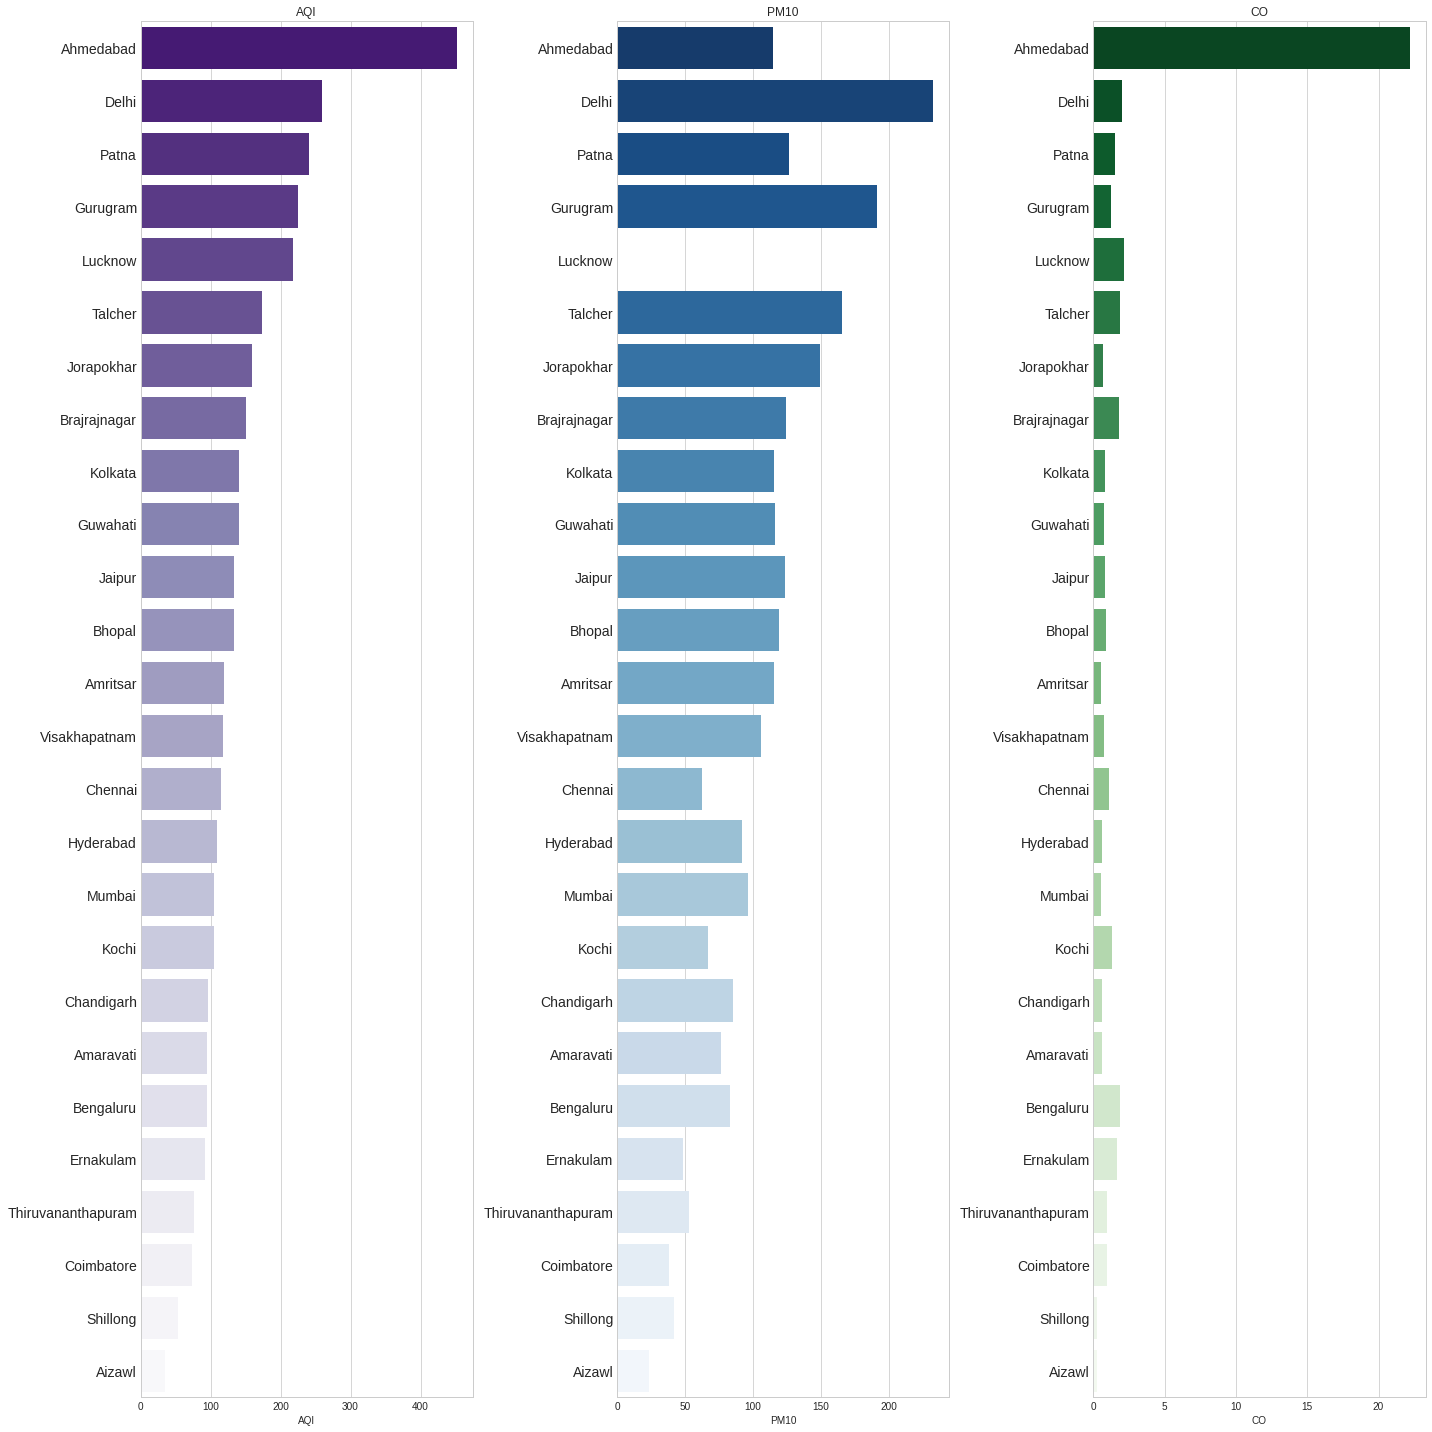

In [ ]:
plt.style.use('seaborn-whitegrid')
f, ax_ = plt.subplots(1, 3, figsize = (20,20))

bar1 = sns.barplot(x = most_polluted.AQI,
                   y = most_polluted.index,
                   palette = 'Purples_r',
                   ax = ax_[0]);

bar1 = sns.barplot(x = most_polluted.PM10,
                   y = most_polluted.index,
                   palette = 'Blues_r',
                   ax = ax_[1]);

bar1 = sns.barplot(x = most_polluted.CO,
                   y = most_polluted.index,
                   palette = 'Greens_r',
                   ax = ax_[2]);

titles = ['AQI', 'PM10', 'CO']
for i in range(3) :
    ax_[i].set_ylabel('')   
    ax_[i].set_yticklabels(labels = ax_[i].get_yticklabels(),fontsize = 14);
    ax_[i].set_title(titles[i])
    f.tight_layout()

In [ ]:
most_polluted = city_day[['City', 'AQI', 'PM10', 'CO']].groupby(['City']).mean().sort_values(by = 'AQI', ascending = False)

cities = most_polluted.index
params = most_polluted.columns

def first_date(city, parameter):
    df = city_day[(city_day.City == city)]
    df = df[df[parameter].notnull()]
    if len(df) != 0:
        return df.iloc[0].Date.strftime('%Y-%m-%d')
    else: return('no_measurement')
        
        
for city in cities:
    #print(colored('city: ', 'green'), city)
    for param in params:
      #  print('param: ', param)
        most_polluted.loc[city, str(param) + '_date'] = first_date(city, param)
        
most_polluted.head()

,AQI,PM10,CO,AQI_date,PM10_date,CO_date
City,,,,,,
Ahmedabad,452.122939,114.584029,22.193407,2015-01-29,2019-05-14,2015-01-01
Delhi,259.487744,232.809229,1.976053,2015-01-01,2015-01-01,2015-01-01
Patna,240.782042,126.747958,1.533591,2015-10-03,2019-12-24,2015-06-01
Gurugram,225.123882,191.504432,1.257516,2016-01-23,2017-12-31,2015-11-27
Lucknow,217.973059,NaN,2.130328,2015-03-21,no_measurement,2015-01-01


In [ ]:
city_day['Year_Month'] = city_day.Date.apply(lambda x : x.strftime('%Y-%m'))

In [ ]:
df = city_day.groupby(['Year_Month']).sum().reset_index()

# let's only see those that are important to the AQI
# otherwise we will have a messy plot

metrices = corr_with_AQI[corr_with_AQI>0.5].index

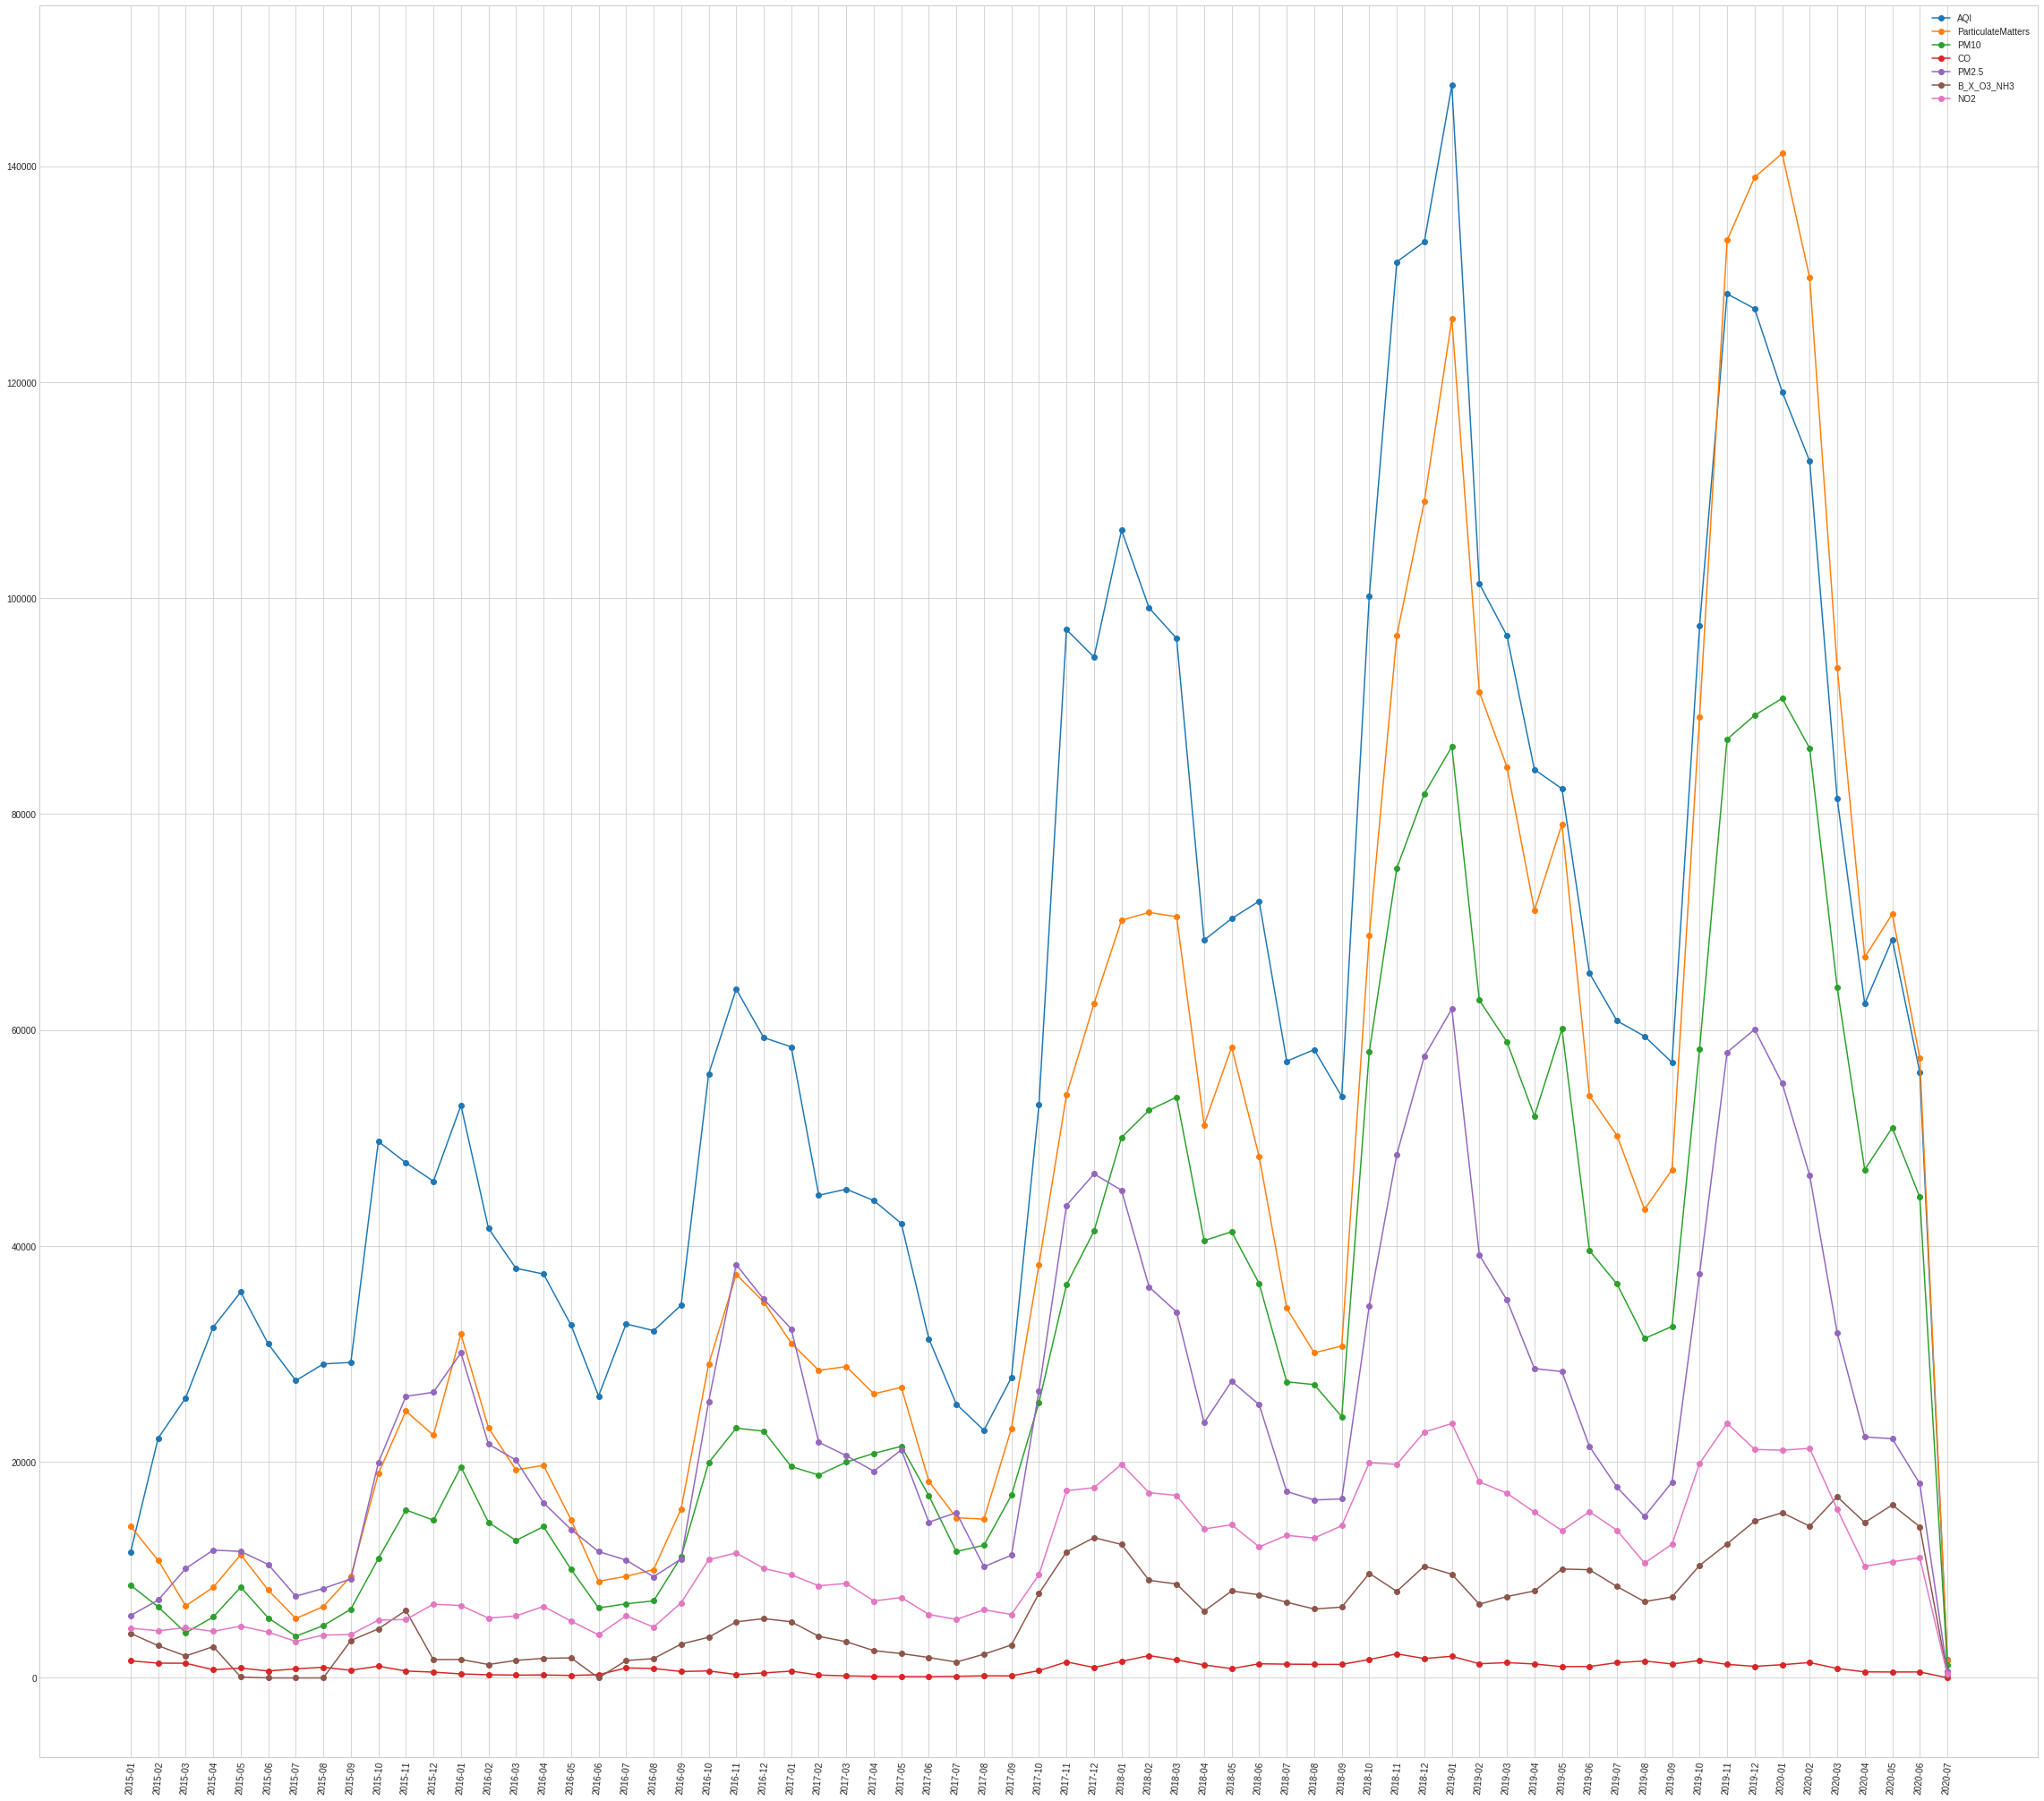

In [ ]:
plt.style.use('seaborn-whitegrid');
fig, ax_ = plt.subplots(figsize=(40,36));

df = city_day.groupby(['Year_Month']).sum().reset_index()

for col in metrices:
    x = df['Year_Month']
    y = df[col]
    
    ax_.plot_date(x ,y ,label=col, linestyle="-");
    
ax_.set_xticklabels(df['Year_Month'], rotation=85);
ax_.legend();

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

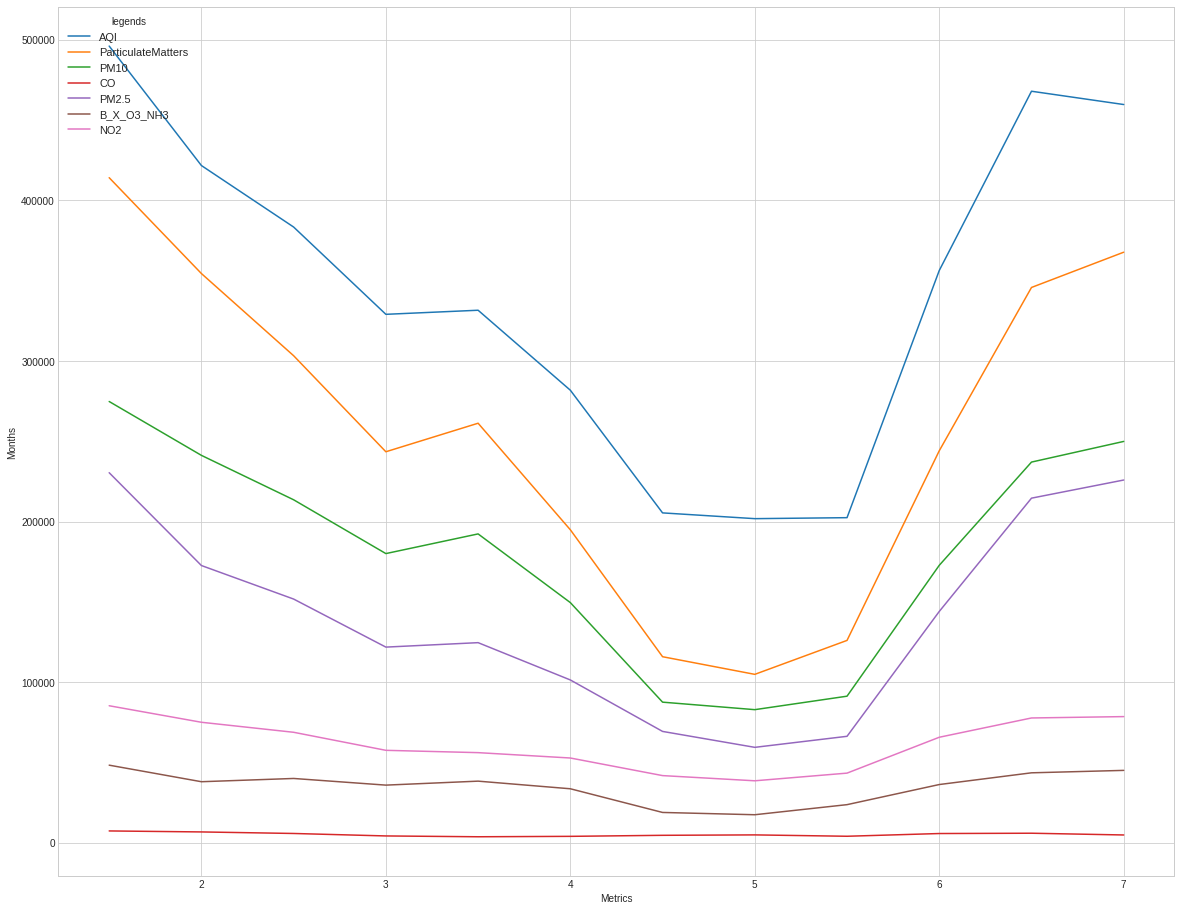

In [ ]:
city_day['Month'] = city_day.Date.dt.month
city_day['Year'] = city_day.Date.dt.year

index = 'Month'
df = city_day.groupby([index]).sum().reset_index()

plt.style.use('seaborn-whitegrid');
fig, ax_ = plt.subplots(figsize=(20,16));


for i, col in enumerate(metrices):
    x = df[index]
    y = df[col]
    plot = sns.lineplot(x ,y );
    

plot.set_xticklabels(df[index], );
ax_.set(xlabel='Metrics', ylabel='Months');
leg = plot.legend(title='legends', loc='upper left', labels=metrices, fontsize = 11);

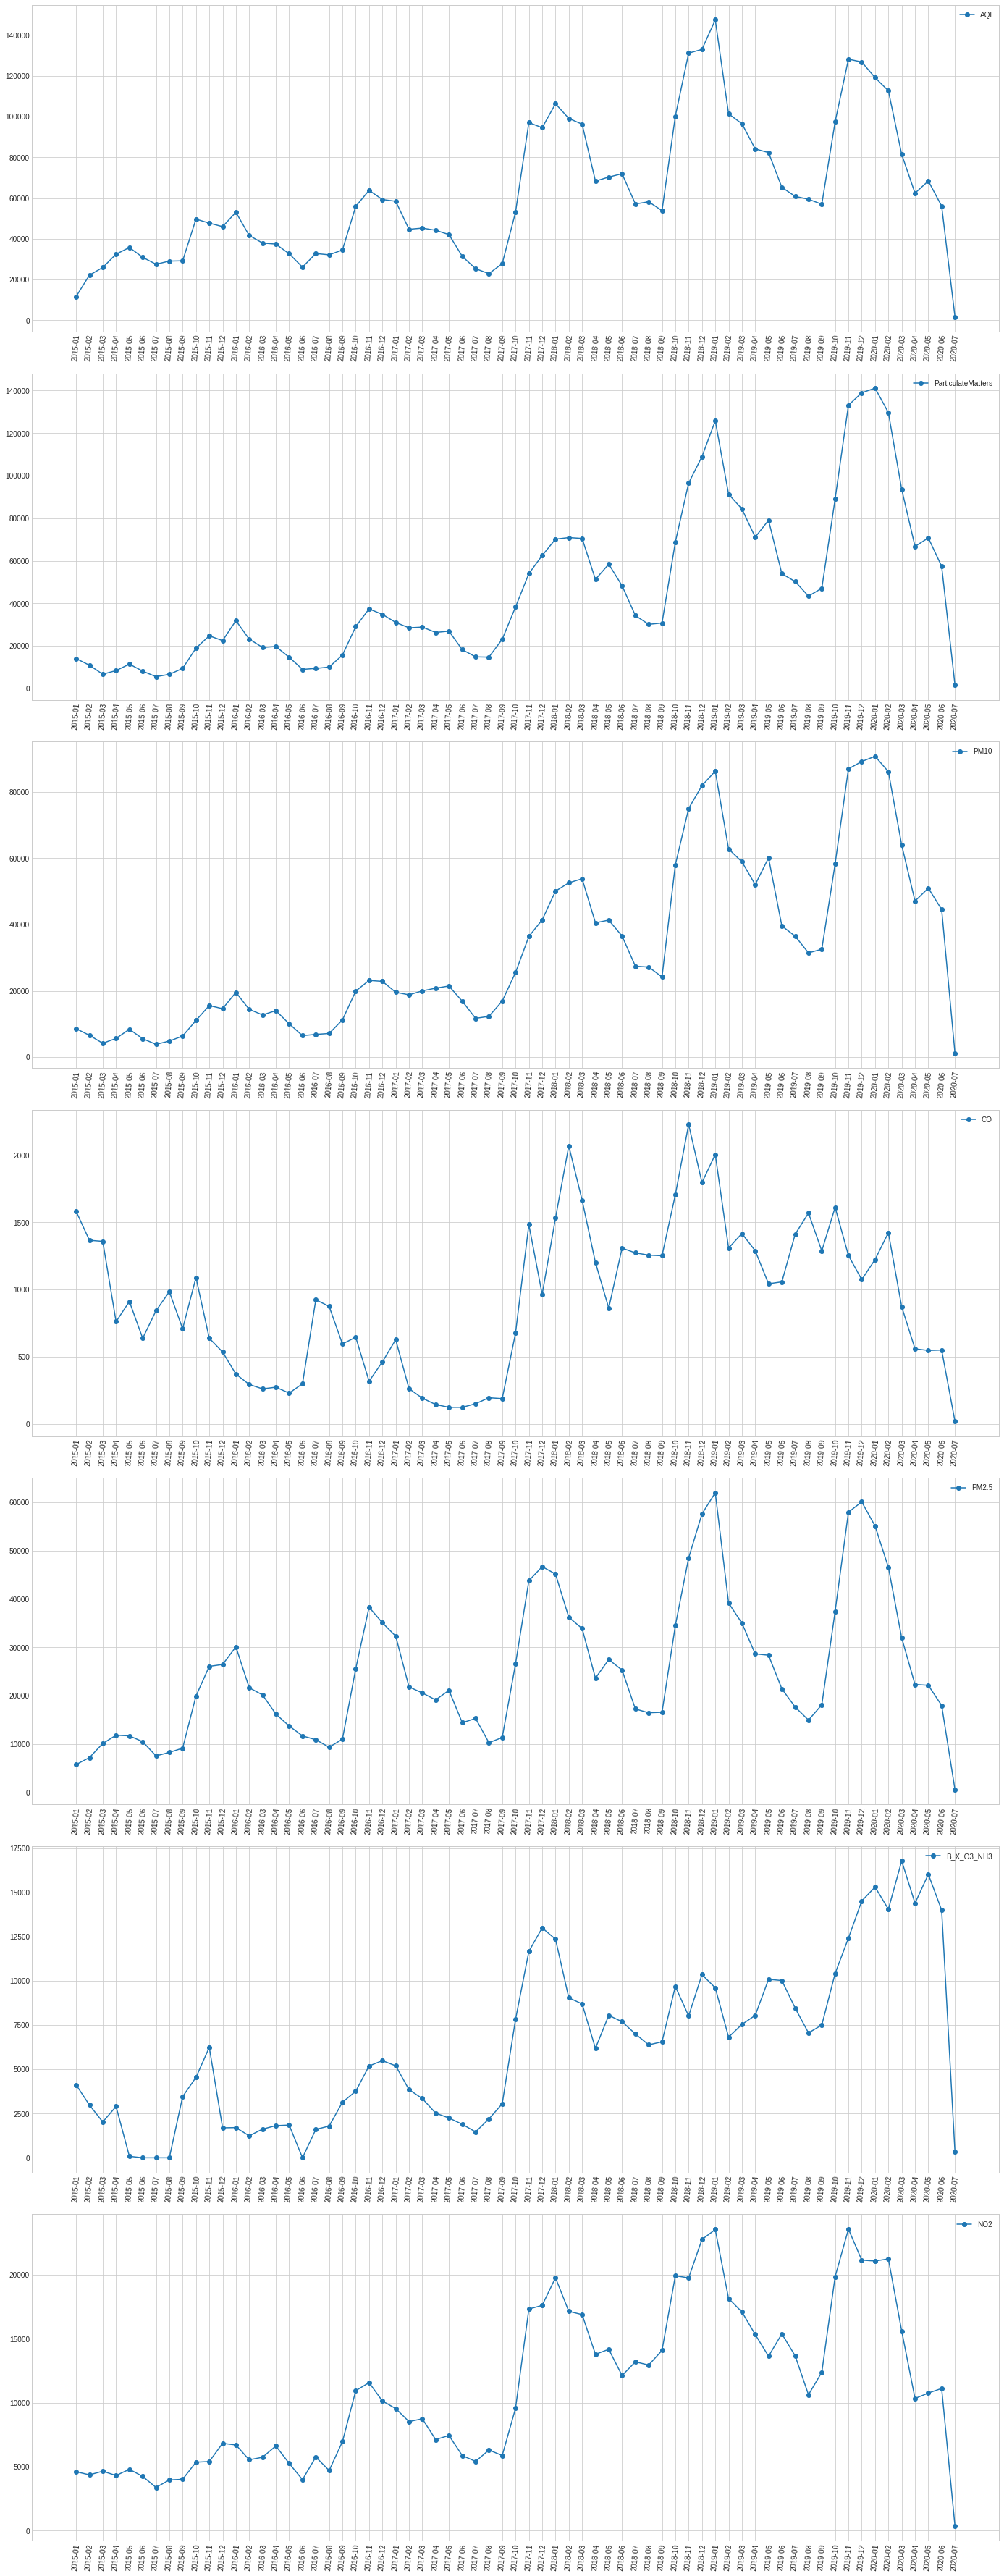

In [ ]:
df = city_day.groupby(['Year_Month']).sum().reset_index()

plt.style.use('seaborn-whitegrid')
fig, ax_ = plt.subplots(len(metrices), 1, figsize=(20,50))

fig.tight_layout(pad=4)
for i, col in enumerate(metrices):
    
    x = df['Year_Month']
    y = df[col]
    ax_[i].plot_date(x ,y ,label=col, linestyle="-")
    ax_[i].set_xticklabels(df['Year_Month'], rotation=85);
    ax_[i].legend();

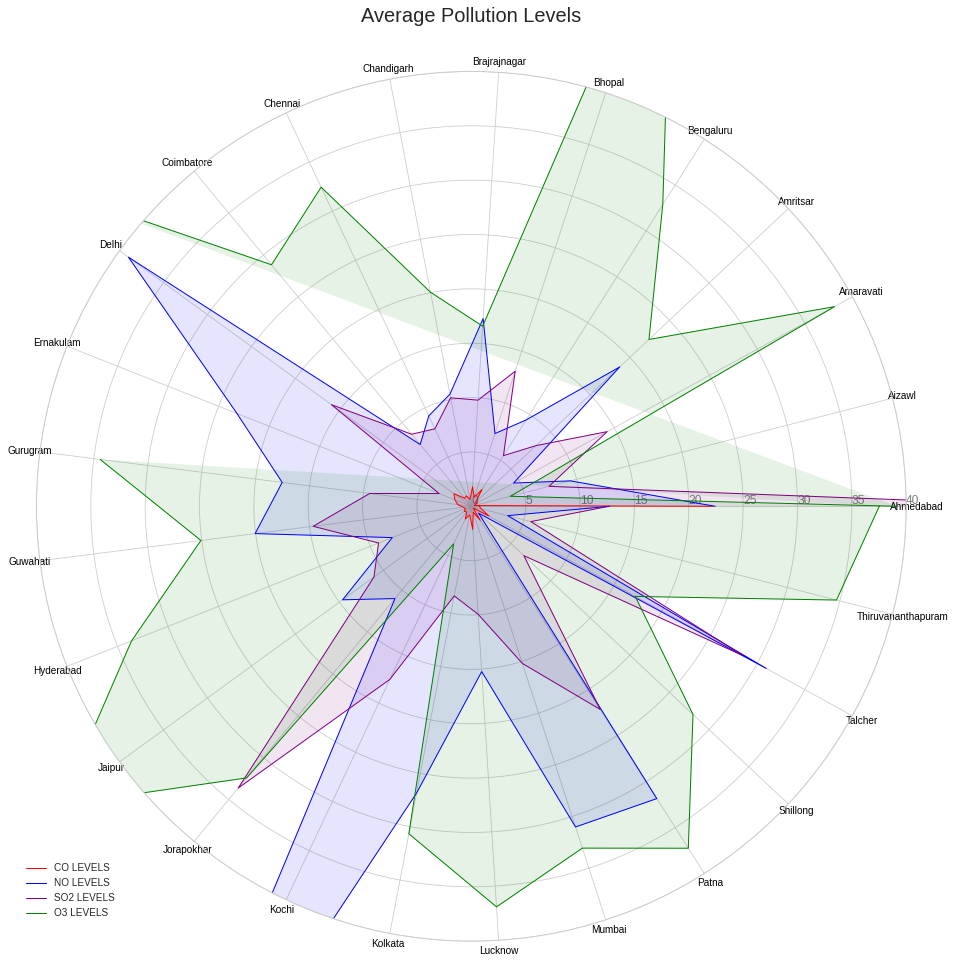

In [81]:
df_CO = city_day.pivot(index='Date', columns='City', values='CO')
df_CO = df_CO.fillna(df_CO.mean())

df_NO = city_day.pivot(index='Date', columns='City', values='NO')
df_NO = df_NO.fillna(df_NO.mean())

df_SO2 = city_day.pivot(index='Date', columns='City', values='SO2')
df_SO2 = df_SO2.fillna(df_SO2.mean())

df_O3 = city_day.pivot(index='Date', columns='City', values='O3')
df_O3 = df_O3.fillna(df_O3.mean())

categories=list(df_CO)[0:]
N = len(categories)

values_co  = df_CO.mean(axis=0)
values_no  = df_NO.mean(axis=0)
values_so2 = df_SO2.mean(axis=0)
values_o3  = df_O3.mean(axis=0)

angles = [n / float(N-1) * 2 * pi for n in range(N-1)]
angles += angles[:1]

 
fig = plt.figure(figsize=(20,16))
ax = plt.subplot(111, polar=True)
 
plt.xticks(angles[:-1], categories, color='black', size=10)
 
ax.set_rlabel_position(0)
plt.yticks([0,5,10,15,20,25,30,35,40], ["0","5","10","15","20","25","30","35","40"], color="grey", size=12)
plt.ylim(0,40)
 
ax.plot(angles, values_co, 'red',linewidth=1, linestyle='solid', label="CO LEVELS")
ax.fill(angles, values_co, 'red', alpha=0.1)

ax.plot(angles, values_no, 'blue',linewidth=1, linestyle='solid', label="NO LEVELS")
ax.fill(angles, values_no, 'blue', alpha=0.1)

ax.plot(angles, values_so2,'purple',linewidth=1, linestyle='solid', label="SO2 LEVELS")
ax.fill(angles, values_so2,'purple', alpha=0.1)

ax.plot(angles, values_o3, 'green',linewidth=1, linestyle='solid', label="O3 LEVELS")
ax.fill(angles, values_o3, 'green', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title("Average Pollution Levels",fontsize=20);

In [ ]:
cities = ['Ahmedabad','Delhi','Bengaluru','Mumbai','Hyderabad','Chennai']

filtered_city_day = city_day[city_day['Date'] >= '2019-01-01']
AQI = filtered_city_day[filtered_city_day.City.isin(cities)][['Date','City','AQI','AQI_Bucket']]
AQI.head()

,Date,City,AQI,AQI_Bucket
23316,2019-01-01,Mumbai,181.0,Moderate
16039,2019-01-01,Hyderabad,132.0,Moderate
11690,2019-01-01,Delhi,475.0,Severe
9295,2019-01-01,Chennai,212.0,Poor
5755,2019-01-01,Bengaluru,128.0,Moderate


In [ ]:
AQI_pivot = AQI.pivot(index='Date', columns='City', values='AQI')
AQI_pivot.fillna(method='bfill',inplace=True)


from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=6, cols=1,
    #specs=[[{}, {}],
          # [{"colspan": 6}, None]],
    subplot_titles=("Ahmedabad","Bengaluru","Chennai","Delhi",'Hyderabad','Mumbai'))

fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Ahmedabad'],
                    marker=dict(color=AQI_pivot['Ahmedabad'],coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Bengaluru'],
                    marker=dict(color=AQI_pivot['Bengaluru'], coloraxis="coloraxis")),
              2, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Chennai'],
                    marker=dict(color=AQI_pivot['Chennai'], coloraxis="coloraxis")),
              3, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Delhi'],
                    marker=dict(color=AQI_pivot['Delhi'], coloraxis="coloraxis")),
              4, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Hyderabad'],
                    marker=dict(color=AQI_pivot['Hyderabad'], coloraxis="coloraxis")),
              5, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Mumbai'],
                    marker=dict(color=AQI_pivot['Mumbai'], coloraxis="coloraxis")),
              6, 1)

fig.update_layout(coloraxis=dict(colorscale='Temps'),showlegend=False,title_text="AQI Levels")

fig.update_layout(plot_bgcolor='white')

fig.update_layout( width=800,height=1200,shapes=[
      dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-03-25', x1= '2020-03-25'
    )
])

fig.show()

**Data Visualization 2.0**

In [ ]:
df_city = pd.read_csv('city_day.csv')
df_stations = pd.read_csv('station_day.csv')
stations = pd.read_csv('stations.csv')

In [ ]:
df_stations = pd.merge(df_stations,stations,how = 'left')
df_stations.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,StationName,City,State,Status
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active


In [ ]:
df_city['AQI'].fillna(method = 'ffill',inplace = True)
df_city['AQI'].fillna(method = 'bfill',inplace = True)
df_city['AQI'].fillna(value = 0,inplace = True)


df_stations['AQI'].fillna(method = 'ffill',inplace = True)
df_stations['AQI'].fillna(method = 'bfill',inplace = True)
df_stations['AQI'].fillna(value = 0,inplace = True)

In [ ]:
def get_AQI_bucket(x):
    
    # Here, x = AQI
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

In [ ]:
city_mean_aqi = df_city.groupby('City')['AQI'].mean()
city_mean_aqi  = pd.DataFrame(city_mean_aqi)
city_mean_aqi['AQI_Bucket'] = city_mean_aqi['AQI'].apply(get_AQI_bucket)
city_mean_aqi['AQI'] = round(city_mean_aqi['AQI'],2)
city_mean_aqi.reset_index(drop = False, inplace = True)

# d = dict(city_data[['City','AQI_Bucket']])

state_aqi_buckets ={'Ahmedabad': 'Severe',
 'Aizawl': 'Good',
 'Amaravati': 'Satisfactory',
 'Amritsar': 'Moderate',
 'Bengaluru': 'Satisfactory',
 'Bhopal': 'Moderate',
 'Brajrajnagar': 'Moderate',
 'Chandigarh': 'Satisfactory',
 'Chennai': 'Moderate',
 'Coimbatore': 'Satisfactory',
 'Delhi': 'Poor',
 'Ernakulam': 'Satisfactory',
 'Gurugram': 'Moderate',
 'Guwahati': 'Moderate',
 'Hyderabad': 'Moderate',
 'Jaipur': 'Moderate',
 'Jorapokhar': 'Moderate',
 'Kochi': 'Moderate',
 'Kolkata': 'Moderate',
 'Lucknow': 'Poor',
 'Mumbai': 'Good',
 'Patna': 'Moderate',
 'Shillong': 'Good',
 'Talcher': 'Moderate',
 'Thiruvananthapuram': 'Satisfactory',
 'Visakhapatnam': 'Satisfactory'}

In [ ]:
#!pip install --upgrade plotly

In [ ]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


In [ ]:
city_aqi_data = df_city[['City','AQI',"Date"]]
city_aqi_data['Average AQI Bucket'] = city_aqi_data['City'].apply(lambda x: state_aqi_buckets[x])

fig2 = px.sunburst(data_frame= city_mean_aqi , path = city_mean_aqi[['AQI_Bucket','City']],template = 'ggplot2',
                   color = city_mean_aqi['AQI_Bucket'], color_discrete_sequence = ["lightgreen", "darkblue", "purple", "lightblue","black"],
                   hover_data = {'AQI_Bucket':False,'AQI': True}, hover_name = 'AQI', title = 'Average AQI (between 2015 and present) and AQI buckets',
                  labels = {'AQI':"Average AQI"})

fig2.update_layout(title = {'text':'State-wise Average AQI (between 2015 and 2020)','y':0.95,'x':0.5,'xanchor':'center'})

fig2.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
dates = pd.to_datetime(df_city['Date'].values)
df_city['month'] = dates.month
df_city['month_name'] = dates.month_name()

aqi_month = df_city.groupby(['month','month_name'])['AQI'].mean().reset_index()
aqi_month['AQI'] = round(aqi_month['AQI'],2)
average = aqi_month['AQI'].mean()

fig =  px.bar(data_frame= aqi_month, x = aqi_month['month_name'], y = (aqi_month['AQI'].values - average) ,color = 'AQI',
       color_continuous_scale=px.colors.sequential.Blues,title = 'The Average AQI of India: ' + str(round(average,2)) +" (from 2015 to 2020)",
       template = 'ggplot2',labels = {'y':'Monthly Variance in AQI from Average ','month_name':''},hover_data={'month_name':False},width = 750,height = 500)

fig.show()

In [ ]:
import chart_studio

In [ ]:
username = 'swash'
api_key = '••••••••••'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [ ]:
import chart_studio.plotly as py
py.plot(fig, filename = 'fig', auto_open=True)

UnicodeEncodeError: ignored

In [ ]:
def tell_me_null(df):
    num_null = df.isnull().sum().sort_values(ascending = False)
    percentage_null = round(df.isnull().sum().sort_values(ascending = False)/len(df) * 100, 1)
    return pd.DataFrame(np.c_[num_null, percentage_null], index = num_null.index,  columns = ['# of Null', 'Percentage'])

In [ ]:
tell_me_null(city_day)

,# of Null,Percentage
B_X_O3_NH3,22788.0,77.2
Xylene,18109.0,61.3
ParticulateMatters,11899.0,40.3
PM10,11140.0,37.7
NH3,10328.0,35.0
Toluene,8041.0,27.2
Benzene,5623.0,19.0
AQI_Bucket,4681.0,15.9
AQI,4681.0,15.9
PM2.5,4598.0,15.6


In [ ]:
delhi = city_day[(city_day.AQI.notnull()) & (city_day.City == 'Delhi')]

In [ ]:
tell_me_null(delhi)

,# of Null,Percentage
B_X_O3_NH3,772.0,38.6
Xylene,771.0,38.6
SO2,102.0,5.1
O3,76.0,3.8
ParticulateMatters,69.0,3.5
PM10,69.0,3.5
NH3,8.0,0.4
PM2.5,1.0,0.1
NO,1.0,0.1
NO2,1.0,0.1


In [ ]:
corr = delhi.corr().AQI.sort_values(ascending = False)
related = list(corr[corr>0.6].index)
print(related)
inter = delhi.loc[:, related].interpolate(method = 'linear');
delhi.loc[:, related] = inter

['AQI', 'ParticulateMatters', 'PM10', 'PM2.5', 'Benzene', 'NO2', 'NO', 'B_X_O3_NH3']


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
knn_imputer = KNNImputer(n_neighbors = 3)

imputing_cols = [ 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'B_X_O3_NH3',
       'ParticulateMatters', 'Month', 'Year']
# we eliminated city, date, Year_Month and AQI_Bucket because 
# they either were unique or had numerical substitude in other fields(AQI_bucket)

knn_imputer.fit(delhi[imputing_cols])

imputed = knn_imputer.transform(delhi[imputing_cols])

delhi.loc[:, imputing_cols] = imputed

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
tell_me_null(delhi)

,# of Null,Percentage
Year,0.0,0.0
SO2,0.0,0.0
Date,0.0,0.0
PM2.5,0.0,0.0
PM10,0.0,0.0
NO,0.0,0.0
NO2,0.0,0.0
NOx,0.0,0.0
NH3,0.0,0.0
CO,0.0,0.0


In [ ]:
from fbprophet import Prophet 

delhi_aqi = delhi[['Date','AQI']]
delhi_aqi.reset_index(inplace = True,drop = True)

train_df = delhi_aqi
train_df.rename(mapper = {'Date':'ds','AQI':'y'},axis =1,inplace = True)
train_df

m = Prophet(holidays_prior_scale=0,seasonality_prior_scale=20,n_changepoints= 50)

m.fit(train_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2359,2021-06-27
2360,2021-06-28
2361,2021-06-29
2362,2021-06-30
2363,2021-07-01


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2359,2021-06-27,12.834775,-73.684868,105.069233
2360,2021-06-28,6.268668,-83.452942,89.029186
2361,2021-06-29,5.477561,-80.036756,90.903069
2362,2021-06-30,6.268677,-76.251165,95.110434
2363,2021-07-01,5.719624,-87.439702,95.002164


In [ ]:
from fbprophet.diagnostics import mape,cross_validation,performance_metrics
df_cv = cross_validation(m, initial='1100 days', period='121 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print('Cross Validation accuracy:', (1 - df_p['mape'].mean())*100)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2018-03-05 00:00:00 and 2019-07-02 00:00:00



Cross Validation accuracy: 68.28420844925361


In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

fig = plot_plotly(m, forecast ,xlabel = 'Date',ylabel= 'AQI',figsize=(1280,720))

fig.show()

In [ ]:
predictions_df=pd.DataFrame(forecast,columns=['ds','yhat'])
predictions_df.to_csv('AQI__Delhi_Predictions.csv',index=False)